<a href="https://colab.research.google.com/github/yastiaisyah/DataSynthesis/blob/main/10_05_24_GAN_Epoch60.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIR = '/content/drive/MyDrive/dataset/real'
os.listdir(DIR)

['human']

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DIR,transform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))
train_dl = DataLoader(train_ds,batch_size,shuffle = True,num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def denorm(img_tensor):
    return img_tensor*stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


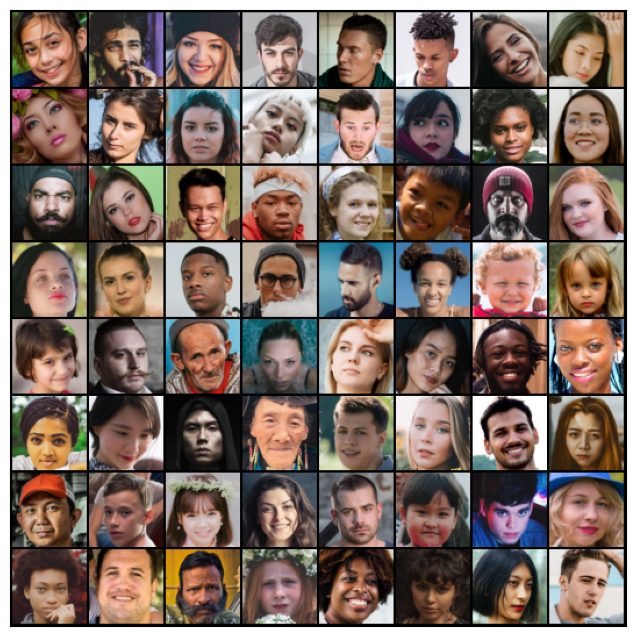

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)

In [ ]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator,device)

In [ ]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


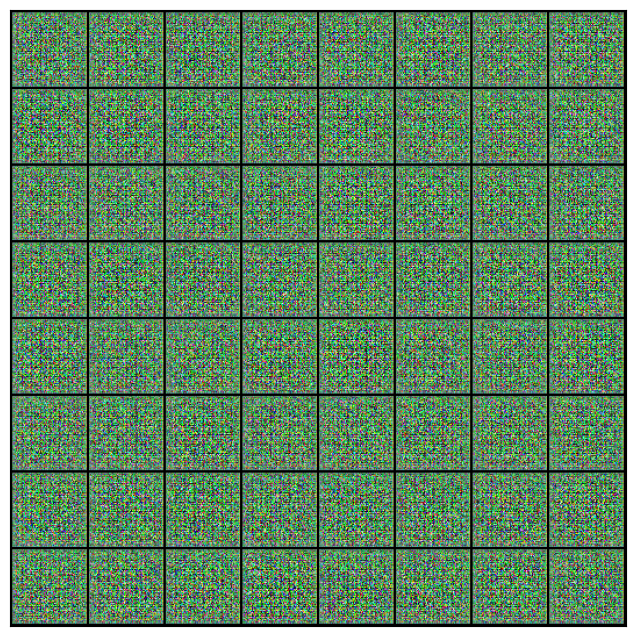

In [ ]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_image = generator(xb)
print(fake_image.shape)
show_images(fake_image)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    print(fake_images.size())
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fixed_latent.shape

torch.Size([64, 128, 1, 1])

torch.Size([64, 3, 64, 64])
Saving generated-images-0000.png


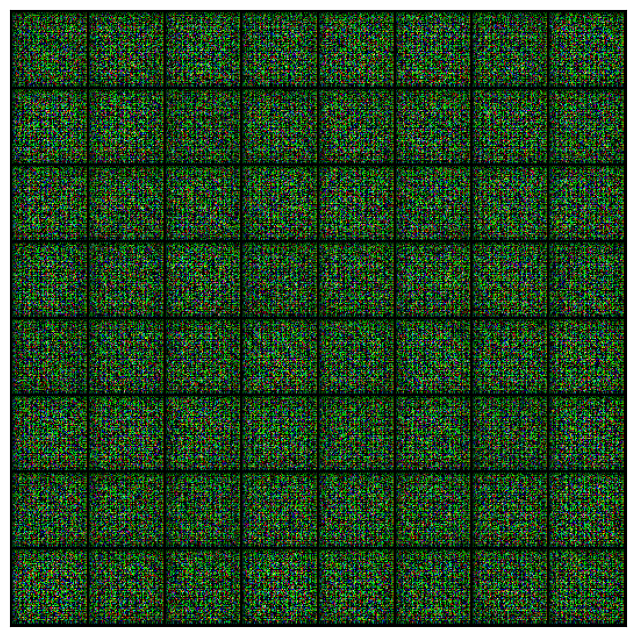

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 60

In [32]:
history = fit(epochs, lr)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 7.9118, loss_d: 0.8289, real_score: 0.8722, fake_score: 0.4384
torch.Size([64, 3, 64, 64])
Saving generated-images-0001.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 7.8983, loss_d: 0.3219, real_score: 0.8158, fake_score: 0.0112
torch.Size([64, 3, 64, 64])
Saving generated-images-0002.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 12.4205, loss_d: 0.1553, real_score: 0.8794, fake_score: 0.0001
torch.Size([64, 3, 64, 64])
Saving generated-images-0003.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 16.4886, loss_d: 0.4950, real_score: 0.7166, fake_score: 0.0000
torch.Size([64, 3, 64, 64])
Saving generated-images-0004.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 14.9005, loss_d: 0.1533, real_score: 0.8853, fake_score: 0.0000
torch.Size([64, 3, 64, 64])
Saving generated-images-0005.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 11.7426, loss_d: 0.0897, real_score: 0.9263, fake_score: 0.0000
torch.Size([64, 3, 64, 64])
Saving generated-images-0006.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 6.0523, loss_d: 0.2248, real_score: 0.9797, fake_score: 0.1679
torch.Size([64, 3, 64, 64])
Saving generated-images-0007.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 6.5512, loss_d: 0.1668, real_score: 0.8748, fake_score: 0.0062
torch.Size([64, 3, 64, 64])
Saving generated-images-0008.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 4.1300, loss_d: 0.2346, real_score: 0.8669, fake_score: 0.0610
torch.Size([64, 3, 64, 64])
Saving generated-images-0009.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 5.7174, loss_d: 0.0795, real_score: 0.9427, fake_score: 0.0147
torch.Size([64, 3, 64, 64])
Saving generated-images-0010.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 5.6478, loss_d: 0.3340, real_score: 0.7648, fake_score: 0.0118
torch.Size([64, 3, 64, 64])
Saving generated-images-0011.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 5.1621, loss_d: 0.1315, real_score: 0.9291, fake_score: 0.0482
torch.Size([64, 3, 64, 64])
Saving generated-images-0012.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 10.9836, loss_d: 2.8224, real_score: 0.8842, fake_score: 0.8078
torch.Size([64, 3, 64, 64])
Saving generated-images-0013.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 0.1351, loss_d: 1.0356, real_score: 0.4618, fake_score: 0.0078
torch.Size([64, 3, 64, 64])
Saving generated-images-0014.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 6.3039, loss_d: 1.2330, real_score: 0.9327, fake_score: 0.6219
torch.Size([64, 3, 64, 64])
Saving generated-images-0015.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 2.4010, loss_d: 0.5252, real_score: 0.7596, fake_score: 0.1916
torch.Size([64, 3, 64, 64])
Saving generated-images-0016.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 2.5378, loss_d: 0.4451, real_score: 0.7576, fake_score: 0.1215
torch.Size([64, 3, 64, 64])
Saving generated-images-0017.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 5.4660, loss_d: 0.8875, real_score: 0.9089, fake_score: 0.4996
torch.Size([64, 3, 64, 64])
Saving generated-images-0018.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.6598, loss_d: 0.5617, real_score: 0.8356, fake_score: 0.2822
torch.Size([64, 3, 64, 64])
Saving generated-images-0019.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 4.3631, loss_d: 2.0416, real_score: 0.2192, fake_score: 0.0024
torch.Size([64, 3, 64, 64])
Saving generated-images-0020.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 2.3199, loss_d: 0.7154, real_score: 0.6301, fake_score: 0.0914
torch.Size([64, 3, 64, 64])
Saving generated-images-0021.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 7.2314, loss_d: 0.8349, real_score: 0.9185, fake_score: 0.4900
torch.Size([64, 3, 64, 64])
Saving generated-images-0022.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 4.0189, loss_d: 0.6147, real_score: 0.8336, fake_score: 0.2928
torch.Size([64, 3, 64, 64])
Saving generated-images-0023.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 6.0212, loss_d: 0.7125, real_score: 0.7968, fake_score: 0.3373
torch.Size([64, 3, 64, 64])
Saving generated-images-0024.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 3.3254, loss_d: 0.5444, real_score: 0.7760, fake_score: 0.2050
torch.Size([64, 3, 64, 64])
Saving generated-images-0025.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 6.7886, loss_d: 1.0226, real_score: 0.9512, fake_score: 0.5831
torch.Size([64, 3, 64, 64])
Saving generated-images-0026.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 2.7284, loss_d: 0.4540, real_score: 0.7374, fake_score: 0.1037
torch.Size([64, 3, 64, 64])
Saving generated-images-0027.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 3.5419, loss_d: 0.4269, real_score: 0.8108, fake_score: 0.1375
torch.Size([64, 3, 64, 64])
Saving generated-images-0028.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 4.8056, loss_d: 0.6541, real_score: 0.9048, fake_score: 0.3920
torch.Size([64, 3, 64, 64])
Saving generated-images-0029.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 2.3839, loss_d: 0.3417, real_score: 0.9562, fake_score: 0.2384
torch.Size([64, 3, 64, 64])
Saving generated-images-0030.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 3.5307, loss_d: 0.4548, real_score: 0.7884, fake_score: 0.1565
torch.Size([64, 3, 64, 64])
Saving generated-images-0031.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.1503, loss_d: 0.4839, real_score: 0.8118, fake_score: 0.2016
torch.Size([64, 3, 64, 64])
Saving generated-images-0032.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 4.6229, loss_d: 0.4626, real_score: 0.8044, fake_score: 0.1777
torch.Size([64, 3, 64, 64])
Saving generated-images-0033.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 5.0674, loss_d: 0.8323, real_score: 0.9490, fake_score: 0.4831
torch.Size([64, 3, 64, 64])
Saving generated-images-0034.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 4.7614, loss_d: 0.8651, real_score: 0.9016, fake_score: 0.4377
torch.Size([64, 3, 64, 64])
Saving generated-images-0035.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 3.5586, loss_d: 0.4812, real_score: 0.8122, fake_score: 0.1896
torch.Size([64, 3, 64, 64])
Saving generated-images-0036.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 5.8887, loss_d: 1.2021, real_score: 0.9184, fake_score: 0.5858
torch.Size([64, 3, 64, 64])
Saving generated-images-0037.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 3.8202, loss_d: 0.3365, real_score: 0.8410, fake_score: 0.1267
torch.Size([64, 3, 64, 64])
Saving generated-images-0038.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 3.2782, loss_d: 0.7004, real_score: 0.6210, fake_score: 0.0579
torch.Size([64, 3, 64, 64])
Saving generated-images-0039.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 1.2466, loss_d: 0.8303, real_score: 0.5555, fake_score: 0.0714
torch.Size([64, 3, 64, 64])
Saving generated-images-0040.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 3.2769, loss_d: 0.4078, real_score: 0.8779, fake_score: 0.2067
torch.Size([64, 3, 64, 64])
Saving generated-images-0041.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 3.9303, loss_d: 0.4469, real_score: 0.8083, fake_score: 0.1666
torch.Size([64, 3, 64, 64])
Saving generated-images-0042.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 4.2038, loss_d: 0.5556, real_score: 0.8386, fake_score: 0.2815
torch.Size([64, 3, 64, 64])
Saving generated-images-0043.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 3.1784, loss_d: 0.5831, real_score: 0.8902, fake_score: 0.3358
torch.Size([64, 3, 64, 64])
Saving generated-images-0044.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 2.4800, loss_d: 0.5708, real_score: 0.6815, fake_score: 0.1112
torch.Size([64, 3, 64, 64])
Saving generated-images-0045.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 1.5379, loss_d: 0.6926, real_score: 0.6491, fake_score: 0.1201
torch.Size([64, 3, 64, 64])
Saving generated-images-0046.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 3.1707, loss_d: 0.3577, real_score: 0.8086, fake_score: 0.1117
torch.Size([64, 3, 64, 64])
Saving generated-images-0047.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 3.4034, loss_d: 0.4096, real_score: 0.7487, fake_score: 0.0750
torch.Size([64, 3, 64, 64])
Saving generated-images-0048.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 4.3993, loss_d: 0.5669, real_score: 0.8724, fake_score: 0.2847
torch.Size([64, 3, 64, 64])
Saving generated-images-0049.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 4.9752, loss_d: 0.5610, real_score: 0.9116, fake_score: 0.3297
torch.Size([64, 3, 64, 64])
Saving generated-images-0050.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 5.1728, loss_d: 0.8015, real_score: 0.9167, fake_score: 0.4267
torch.Size([64, 3, 64, 64])
Saving generated-images-0051.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 4.4507, loss_d: 0.8973, real_score: 0.9448, fake_score: 0.5080
torch.Size([64, 3, 64, 64])
Saving generated-images-0052.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 3.6686, loss_d: 0.5249, real_score: 0.7609, fake_score: 0.1832
torch.Size([64, 3, 64, 64])
Saving generated-images-0053.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 2.5147, loss_d: 0.4165, real_score: 0.8434, fake_score: 0.1757
torch.Size([64, 3, 64, 64])
Saving generated-images-0054.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 3.4888, loss_d: 0.4639, real_score: 0.8135, fake_score: 0.1938
torch.Size([64, 3, 64, 64])
Saving generated-images-0055.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 2.2245, loss_d: 0.5561, real_score: 0.6800, fake_score: 0.0876
torch.Size([64, 3, 64, 64])
Saving generated-images-0056.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 3.8818, loss_d: 0.4305, real_score: 0.8507, fake_score: 0.1981
torch.Size([64, 3, 64, 64])
Saving generated-images-0057.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 3.1915, loss_d: 0.4578, real_score: 0.7551, fake_score: 0.1029
torch.Size([64, 3, 64, 64])
Saving generated-images-0058.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 3.5920, loss_d: 0.7777, real_score: 0.5329, fake_score: 0.0119
torch.Size([64, 3, 64, 64])
Saving generated-images-0059.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 2.4684, loss_d: 1.2087, real_score: 0.4082, fake_score: 0.0212
torch.Size([64, 3, 64, 64])
Saving generated-images-0060.png


In [33]:
losses_g, losses_d, real_scores, fake_scores = history

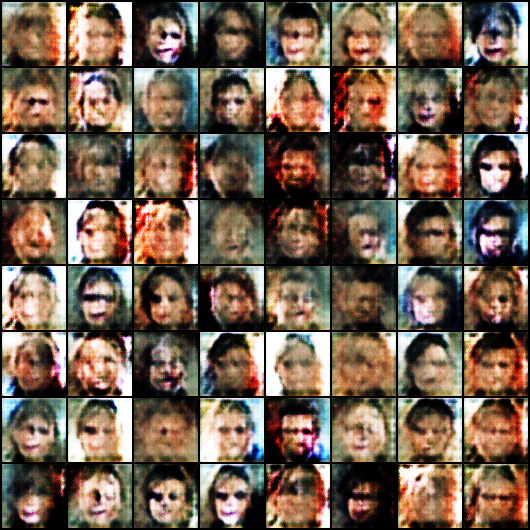

In [34]:
from IPython.display import Image
Image('./generated/generated-images-0060.png')

In [35]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

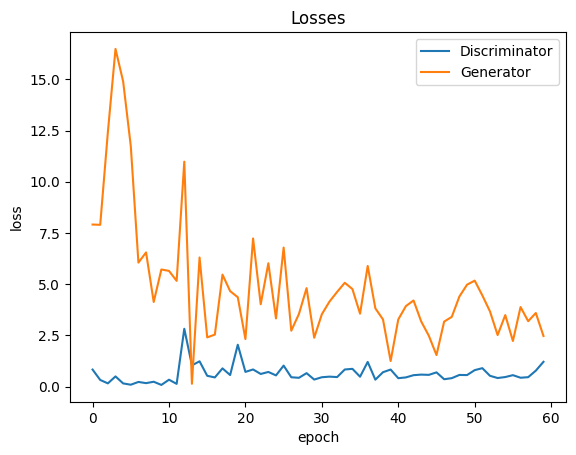

In [36]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

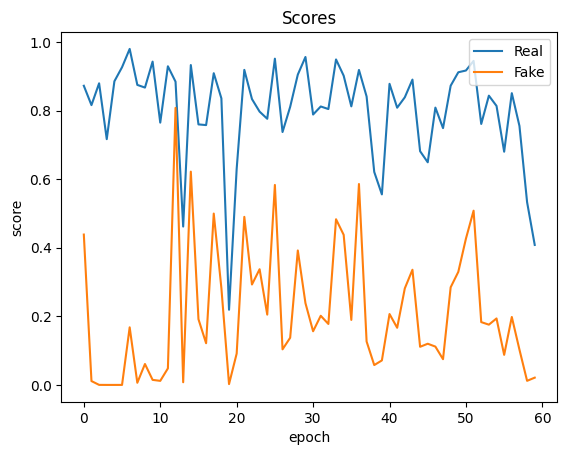

In [37]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');